## Import Library and Utility Function


In [1]:
import os
import json
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Embedding, Dense, Input, MultiHeadAttention, LayerNormalization, Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Fungsi untuk memuat kata-kata dari file
def load_words(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        words = file.read().splitlines()
    return words

# Fungsi untuk memuat kata-kata slang
def load_slang_words(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        slang_dict = json.loads(file.read())
    return slang_dict

# Fungsi untuk membaca file teks dari folder
def read_text_files(folder_path):
    texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                content = file.read().strip().lower()
                if content:  # Check if the file is not empty
                    cleaned_content = clean_text(content)
                    texts.append(cleaned_content)
    return texts

# Fungsi untuk membaca file sampling
def read_sampling_files(folder_path, num_files=100):
    texts = []
    filenames = [f for f in os.listdir(folder_path) if f.endswith(".txt")]
    sampled_filenames = filenames[:num_files]  # Ambil hanya sejumlah file yang diperlukan
    for filename in sampled_filenames:
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
            content = file.read().strip().lower()
            if content:  # Check if the file is not empty
                cleaned_content = clean_text(content)
                texts.append(cleaned_content)
    return texts


# Fungsi untuk membersihkan teks
def clean_text(text):
    unwanted_chars = ['*', '#', '_', ')', '(', '!', '?', '.', ',', '-']
    for char in unwanted_chars:
        text = text.replace(char, '')
    return text

## Configure GPU

In [2]:
# Konfigurasi Memori GPU dan Mixed Precision Training
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])  # Set memory limit to 2GB
    except RuntimeError as e:
        print(e)

from tensorflow.keras.mixed_precision import Policy, set_global_policy
policy = Policy('mixed_float16')
set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU, compute capability 8.6


## Load Data

In [15]:
# Memuat data untuk dataset 1 (kosakata)
# Memuat data untuk dataset 1 (kosakata)
root_words = [word.lower() for word in load_words('../Dataset/indonesian_word/combined_root_words.txt')]
stop_words = [word.lower() for word in load_words('../Dataset/indonesian_word/combined_stop_words.txt')]
slang_dict = {k.lower(): v.lower() for k, v in load_slang_words('../Dataset/indonesian_word/combined_slang_words.txt').items()}

# Gabungkan semua kata untuk pembentukan kosakata
all_words = list(set(root_words + stop_words + list(slang_dict.keys()) + list(slang_dict.values())))

# Memuat dataset 2 (paragraf tentang Python)
dataset2_texts = read_text_files('../Dataset/nlp_dataset')

# Memuat dataset 2 dengan metode sampling
dataset2_sampling = read_sampling_files('../Dataset/nlp_dataset', num_files=4)

In [16]:
# Menghitung dan mencetak jumlah kata dalam dataset 2
total_words_dataset1 = sum(len(text.split()) for text in all_words)
print(f'Total jumlah kata dalam dataset 2: {total_words_dataset1}')

Total jumlah kata dalam dataset 2: 30076


In [17]:
# Menghitung dan mencetak jumlah kata dalam dataset 2
total_words_dataset2 = sum(len(text.split()) for text in dataset2_sampling)
print(f'Total jumlah kata dalam dataset 2: {total_words_dataset2}')

Total jumlah kata dalam dataset 2: 4381


## Data Prepeare

In [9]:
# Tokenizer untuk dataset 1
tokenizer = Tokenizer(num_words=len(all_words), oov_token='<OOV>')
tokenizer.fit_on_texts(all_words)

# Tokenisasi dan padding untuk dataset 1
dataset1_sequences = tokenizer.texts_to_sequences(all_words)
dataset1_padded = pad_sequences(dataset1_sequences, padding='post')

# Dataset dan target untuk pelatihan
dataset1_inputs = dataset1_padded[:, :-1]
dataset1_targets = dataset1_padded[:, 1:]

# Create a dataset from the input and target sequences
train_dataset1 = tf.data.Dataset.from_tensor_slices((dataset1_inputs, dataset1_targets))
train_dataset1 = train_dataset1.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

## Arsitektur words model

In [10]:
# Hyperparameters
embedding_dim = 32
lstm_units = 4
vocab_size = len(all_words)  # Adjust based on your vocabulary size

# Input Layer
inputs = Input(shape=(None,), name="inputs")

# Embedding Layer
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="embedding_layer")(inputs)

# LSTM Layer
lstm_output = LSTM(lstm_units, return_sequences=True, name="lstm_layer")(embedding)

# Output Layer for Vocabulary Understanding
outputs = Dense(vocab_size, activation='softmax', name="output_layer")(lstm_output)

# Model
vocab_model = Model(inputs=inputs, outputs=outputs, name="vocab_model")

# Compile Model 1
optimizer_model1 = Adam()
vocab_model.compile(optimizer=optimizer_model1, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

vocab_model.summary()

Model: "vocab_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None)]            0         
                                                                 
 embedding_layer (Embedding)  (None, None, 32)         948576    
                                                                 
 lstm_layer (LSTM)           (None, None, 4)           592       
                                                                 
 output_layer (Dense)        (None, None, 29643)       148215    
                                                                 
Total params: 1,097,383
Trainable params: 1,097,383
Non-trainable params: 0
_________________________________________________________________


## Train Words model

In [11]:
# Train the model with dataset 1
vocab_model.fit(train_dataset1, epochs=5)

# Save the model
vocab_model.save('../saved_model/base_model_saved/base_model_05/base_model.h5')

Epoch 1/5
927/927 [==============================] - 19s 14ms/step - loss: 5.6538 - accuracy: 0.9936
Epoch 2/5
927/927 [==============================] - 12s 13ms/step - loss: 0.6546 - accuracy: 0.9943
Epoch 3/5
927/927 [==============================] - 12s 13ms/step - loss: 0.1427 - accuracy: 0.9943
Epoch 4/5
927/927 [==============================] - 12s 13ms/step - loss: 0.0889 - accuracy: 0.9943
Epoch 5/5
927/927 [==============================] - 12s 13ms/step - loss: 0.0739 - accuracy: 0.9943


## Dataset 2 Prep

In [18]:
# Load dataset 2 (paragraf tentang Python)
dataset2_texts = read_text_files('../Dataset/nlp_dataset')

# Tokenisasi dan padding untuk dataset 2
dataset2_sequences = tokenizer.texts_to_sequences(dataset2_sampling)
dataset2_padded = pad_sequences(dataset2_sequences, padding='post')

dataset2_inputs = dataset2_padded[:, :-1]
dataset2_targets = dataset2_padded[:, 1:]

# Split data into training and validation sets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    dataset2_inputs, dataset2_targets, test_size=0.2, random_state=42)

train_dataset2 = tf.data.Dataset.from_tensor_slices((train_inputs, train_targets)).shuffle(buffer_size=1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset2 = tf.data.Dataset.from_tensor_slices((val_inputs, val_targets)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)


## Arsitektur Self-Attention Model

In [19]:
# Load the saved model
vocab_model = tf.keras.models.load_model('../saved_model/base_model_saved/base_model_05/base_model.h5')

# Extract the embedding layer's weights
embedding_weights = vocab_model.get_layer('embedding_layer').get_weights()

# Define the Self-Attention model (Model 2)
def transformer_layer(x, d_model, num_heads, dff, rate=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = Dropout(rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    
    ffn_output = tf.keras.Sequential([
        Dense(dff, activation='relu'), 
        Dense(d_model)])(out1)
    
    ffn_output = Dropout(rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    
    return out2

num_transformer_layers = 2
num_heads = 4
dff = 256  # Adjusted to maintain a reasonable number of parameters

# Define the new model architecture
inputs_model2 = Input(shape=(None,), name="inputs")
embedding_layer_model2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="embedding_layer")
embedding_model2 = embedding_layer_model2(inputs_model2)
embedding_layer_model2.set_weights(embedding_weights)

transformer_output = embedding_model2
for _ in range(num_transformer_layers):
    transformer_output = transformer_layer(transformer_output, embedding_dim, num_heads, dff)

outputs_model2 = Dense(vocab_size, activation='softmax', name="output_layer")(transformer_output)

context_model = Model(inputs=inputs_model2, outputs=outputs_model2, name="context_model")

# Compile without wrapping optimizer (using the mixed_precision policy)
context_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
context_model.summary()


Model: "context_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, None, 32)     948576      ['inputs[0][0]']                 
                                                                                                  
 multi_head_attention_2 (MultiH  (None, None, 32)    16800       ['embedding_layer[0][0]',        
 eadAttention)                                                    'embedding_layer[0][0]']        
                                                                                                  
 dropout_4 (Dropout)            (None, None, 32)     0           ['multi_head_attentio

In [20]:
# Train the model with dataset 2
history = context_model.fit(train_dataset2, validation_data=val_dataset2, epochs=2000)

# Save the updated model
context_model.save('../saved_model/base_model_saved/base_model_05/updated_model.h5')


Epoch 1/2000
1/1 [==============================] - 2s 2s/step - loss: 10.2969 - accuracy: 0.0000e+00 - val_loss: 10.2344 - val_accuracy: 0.0024
Epoch 2/2000
1/1 [==============================] - 0s 151ms/step - loss: 10.2344 - accuracy: 0.0056 - val_loss: 10.1797 - val_accuracy: 0.2198
Epoch 3/2000
1/1 [==============================] - 0s 150ms/step - loss: 10.1875 - accuracy: 0.1961 - val_loss: 10.1328 - val_accuracy: 0.2526
Epoch 4/2000
1/1 [==============================] - 0s 149ms/step - loss: 10.1328 - accuracy: 0.2603 - val_loss: 10.0781 - val_accuracy: 0.2526
Epoch 5/2000
1/1 [==============================] - 0s 146ms/step - loss: 10.0781 - accuracy: 0.2848 - val_loss: 10.0234 - val_accuracy: 0.2526
Epoch 6/2000
1/1 [==============================] - 0s 150ms/step - loss: 10.0234 - accuracy: 0.2952 - val_loss: 9.9688 - val_accuracy: 0.2526
Epoch 7/2000
1/1 [==============================] - 0s 145ms/step - loss: 9.9688 - accuracy: 0.2974 - val_loss: 9.9062 - val_accuracy: 0

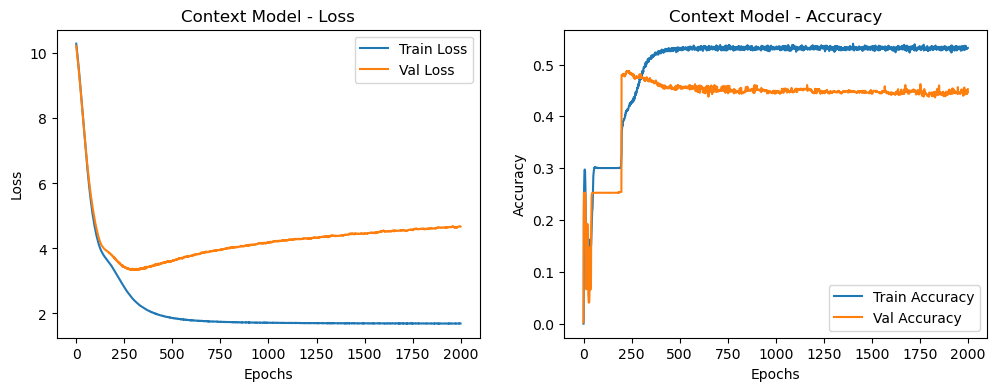

In [21]:
# Visualisasi training dan validation loss dan accuracy
def plot_metrics(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{title} - Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{title} - Accuracy')
    
    plt.show()
    

# Plot metrics untuk context_model
plot_metrics(history, 'Context Model')

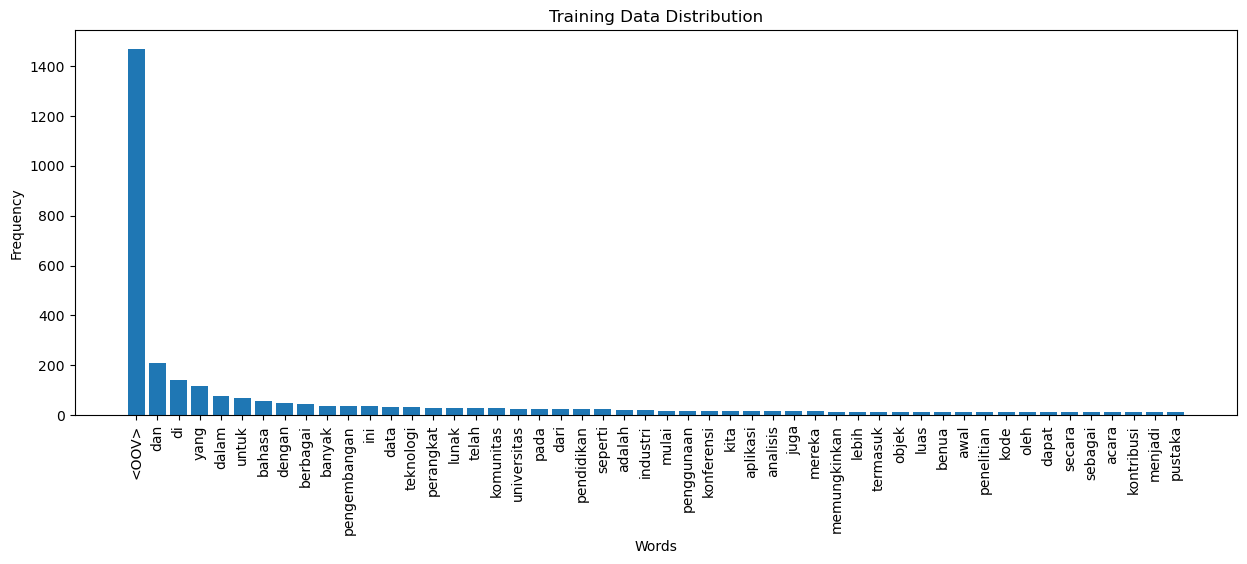

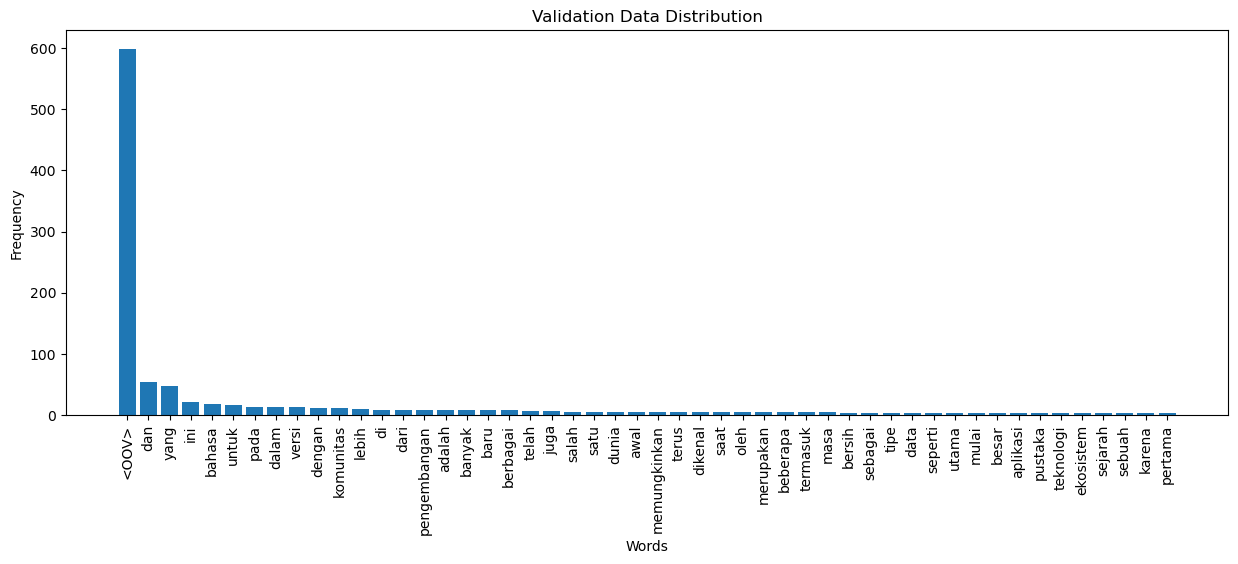

In [22]:
import matplotlib.pyplot as plt

def plot_data_distribution(dataset, title):
    word_counts = {}
    
    for batch in dataset.take(5):  # Take 5 batches for visualization
        inputs, targets = batch
        for sequence in inputs.numpy():
            for word_id in sequence:
                word = tokenizer.index_word.get(word_id, '<OOV>')
                if word in word_counts:
                    word_counts[word] += 1
                else:
                    word_counts[word] = 1
    
    # Sort the word counts
    sorted_word_counts = sorted(word_counts.items(), key=lambda kv: kv[1], reverse=True)
    sorted_words, sorted_counts = zip(*sorted_word_counts[:50])  # Take top 50 words for visualization

    plt.figure(figsize=(15, 5))
    plt.bar(sorted_words, sorted_counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

# Visualize data distribution for training set
plot_data_distribution(train_dataset2, 'Training Data Distribution')

# Visualize data distribution for validation set
plot_data_distribution(val_dataset2, 'Validation Data Distribution')


In [23]:
# Evaluasi model context
context_model.evaluate(val_dataset2)

1/1 [==============================] - 0s 244ms/step - loss: 4.6719 - accuracy: 0.4524


[4.671875, 0.4524380564689636]

In [24]:
def generate_text(model, start_string, num_generate=100):
    # Convert start string to tokens
    input_eval = [tokenizer.word_index[s] for s in start_string.split() if s in tokenizer.word_index]
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_generated = []
    
    # Reset states for stateful LSTM models
    model.reset_states()
    
    for _ in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        # Use a categorical distribution to predict the word returned by the model
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        
        # Pass the predicted word as the next input to the model
        input_eval = tf.expand_dims([predicted_id], 0)
        
        # Append the predicted word to the generated text
        if predicted_id in tokenizer.index_word:
            text_generated.append(tokenizer.index_word[predicted_id])
        else:
            text_generated.append("<UNK>")  # Token for unknown words
    
    return start_string + ' ' + ' '.join(text_generated)

# Generate text
print(generate_text(context_model, start_string="apa itu python", num_generate=100))


apa itu python kuntul duratif kerakap laksmi gadungan tenun still gohok etnolog nekromansi majizat paradam jori renstra atelir eskatologis monosit tempat pesenan pabrikasi sewah ambliobia keprak bakar paitua genjot lanar bancik deru muker cerucup ampo sagang marikh kontraktor apnea kalikausar kemung dikromatik imperatif marjinal sanitas lagau legunder italik linen serompok rokade mardatillah buset letup rengges endodermis ledre sensitif upakarti kelebet cuma latung kuncung aerologi tabal siri satin kykny kardamunggu viabilitas flensa retail tutut polisi seterusnya merak konsumer tabelaris gita uman limnetik troposfer fatah timbau jagapati musara blantika doktor delta faktor pawaka kelinjat dungkul fagosit pertanyakan sportif alomorf konjungtivitis tingkrang diplomatik berat sesuai avirulen
